In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias, calculate_bias_fhv, calculate_bias_flv, load_metrics
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [3]:
models = {
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#999999",
                ls = "--",
                  ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = '#984ea3',
                   ls = "-",
                 ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
               r"rst\PBHM-HLSTM",
               is_final_model = True,
               color = "#e41a1c",
               ls = "-",
              )
     }

In [4]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "fhv" : calculate_bias_fhv(dfp.qmeasval.values, dfp.qsim.values),
          "flv" : calculate_bias_flv(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

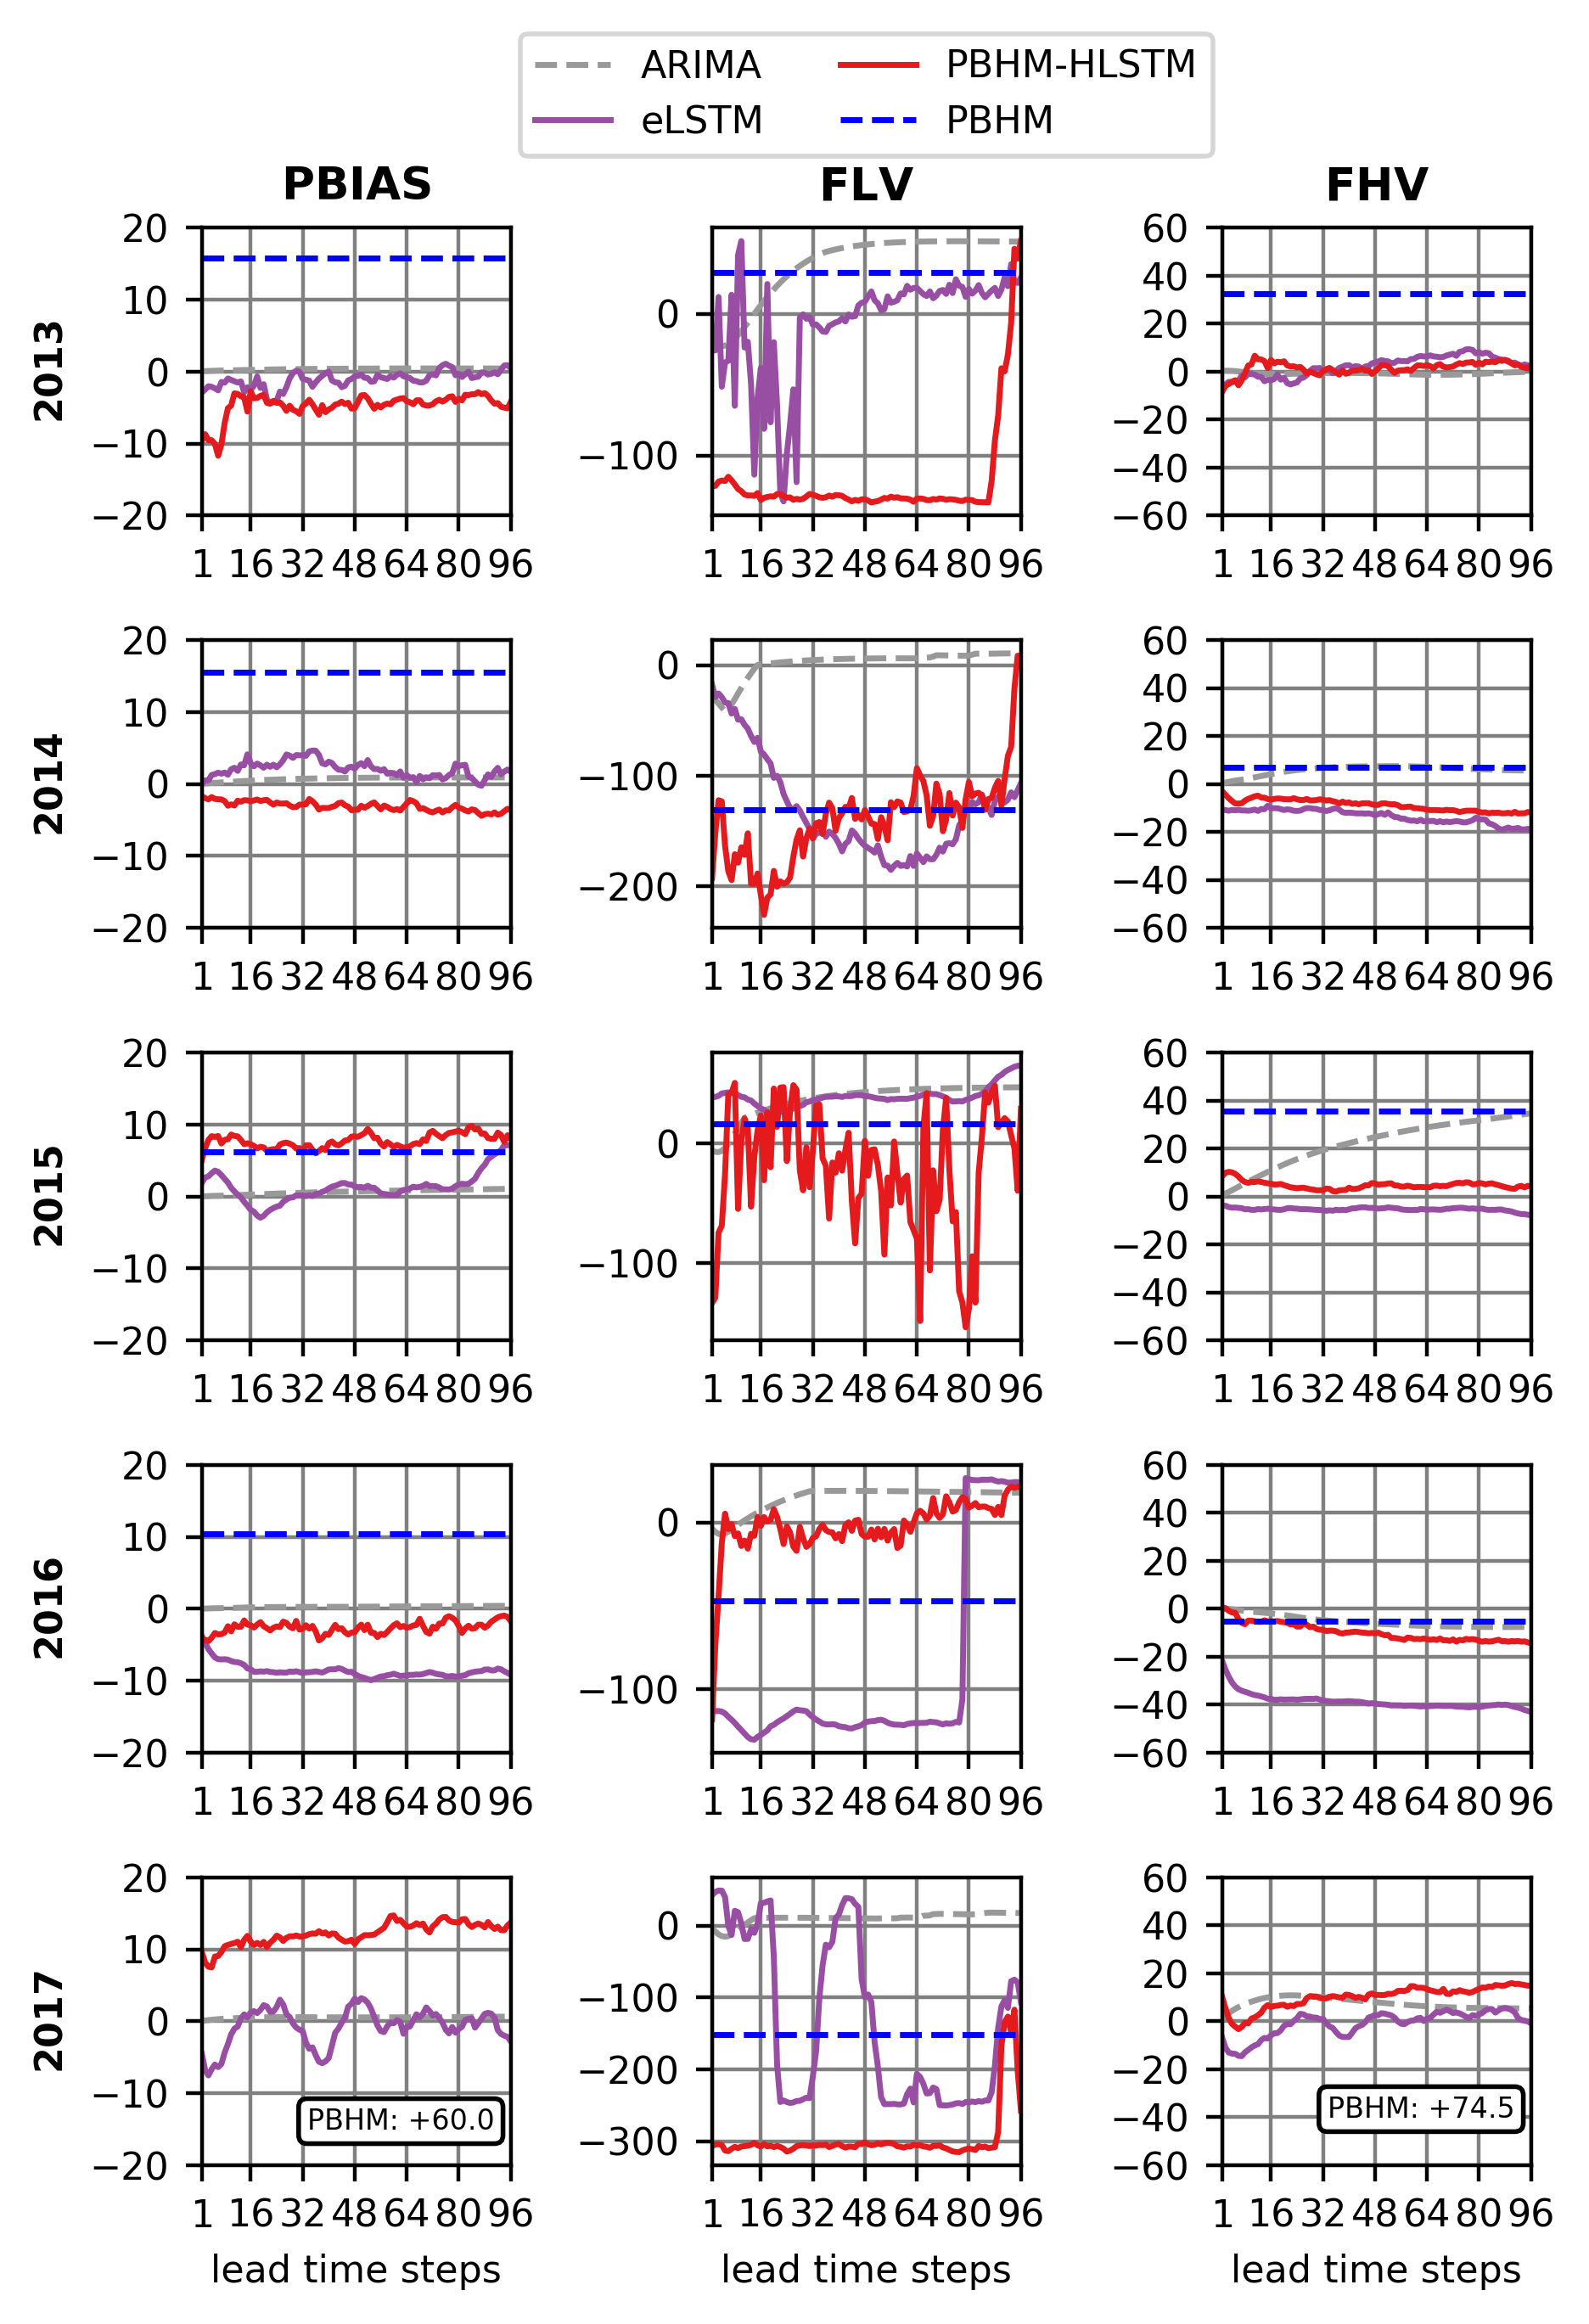

In [5]:
fig, axes = plt.subplots(5,3,figsize=(4.72,6.5), dpi=400)

metric_names = ["bias", "flv", "fhv"]
metric_labels = ["PBIAS", "FLV", "FHV"]
ylims = [(0,1), (-2,1), (-20,10)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "bias_pass", "flv_pass", "fhv_pass",
                           "bias_min", "bias_avg", "bias_max", 
                           "flv_min", "flv_avg", "flv_max", 
                           "fhv_min", "fhv_avg", "fhv_max"])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    if models[key].name != "ARIMA":
        for j, met in enumerate(metric_names):
            metric  = metrics["test"][met]
            for i in range(5):
                df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
                df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                               np.mean(metric[i]), 
                                                                               np.max(metric[i])]
                df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
                
                xx = np.arange(1,np.array(metric[i]).shape[0]+1)
                axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1.25)
    else:          
        for j, met in enumerate(metric_names):
            metric  = metrics["test"][met]
            for i in range(5):
                df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
                df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                               np.mean(metric[i]), 
                                                                               np.max(metric[i])]
                df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
                xx = np.arange(1,np.array(metric[i]).shape[0]+1)
                axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label="ARIMA", lw=1.25)


for i in range(5):
    for j in range(3):
        
        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "--", label="PBHM", lw=1.25)
        if (i == 4) & (j == 0):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-15, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-40, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
        
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")
 
        axes[i,j].set_xticks([1,16,32,48,64,80,96])
        
        if j == 1:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(100))
        elif j == 0:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].set_ylim((-20,20))
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(20))
            axes[i,j].set_ylim((-60,60))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(0.5, 1.25), 
                 loc='lower center', ncol=2, 
                 borderaxespad=0)


In [9]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'fig6_leadtime_performance-bias.png'), bbox_inches="tight")

In [7]:
dft = df.drop(df.columns[2:14], axis=1)
arima   = dft.loc[0:4,:].values[:,2:]
hlstmpb = dft.loc[5:9,:].values[:,2:]
hlstm   = dft.loc[10:,:].values[:,2:]
dft

,name,year,bias_0,bias_1,bias_2,bias_3,bias_4,bias_5,bias_6,bias_7,...,fhv_86,fhv_87,fhv_88,fhv_89,fhv_90,fhv_91,fhv_92,fhv_93,fhv_94,fhv_95
0,ARIMA,2013,0.038485,0.069624,0.091396,0.112313,0.129236,0.141717,0.153519,0.164575,...,-0.508383,-0.450898,-0.392185,-0.333391,-0.279187,-0.226470,-0.174485,-0.119900,-0.065469,-0.011318
1,ARIMA,2014,0.038939,0.075525,0.110620,0.145182,0.177332,0.205456,0.232383,0.259132,...,5.839719,5.793820,5.756343,5.726351,5.702725,5.688428,5.673891,5.663186,5.653661,5.640614
2,ARIMA,2015,0.020277,0.037922,0.054620,0.070169,0.084447,0.098391,0.112449,0.126916,...,32.999737,33.182716,33.365608,33.553377,33.746005,33.940589,34.132818,34.322829,34.512989,34.700103
3,ARIMA,2016,0.023539,0.044086,0.063143,0.077974,0.088737,0.097354,0.105496,0.114365,...,-7.557014,-7.559073,-7.561154,-7.560228,-7.555019,-7.545778,-7.536069,-7.526054,-7.513581,-7.501014
4,ARIMA,2017,0.060921,0.117470,0.170516,0.218188,0.260214,0.297142,0.329778,0.359335,...,5.462501,5.446501,5.427503,5.410554,5.396389,5.384881,5.373468,5.363405,5.352435,5.340759
5,eLSTM,2013,-2.882122,-2.494546,-2.025355,-2.114536,-2.325013,-2.600890,-1.432428,-1.538315,...,5.042102,4.746700,4.080130,3.641682,3.761315,2.994902,2.493076,2.984732,2.661494,0.937166
6,eLSTM,2014,0.003540,0.510816,0.501753,1.263953,1.381997,1.574791,1.445773,1.599311,...,-19.048086,-18.624189,-18.124078,-18.688425,-18.565724,-18.284430,-18.905110,-18.926182,-18.699495,-18.912759
7,eLSTM,2015,1.914989,2.635857,2.797558,3.240331,3.599850,3.422127,2.966279,2.440470,...,-5.454429,-5.842546,-5.994163,-6.245912,-6.733300,-7.077306,-7.358808,-7.348756,-7.619036,-7.830905
8,eLSTM,2016,-3.772399,-4.688900,-5.586345,-6.199916,-6.751787,-6.994629,-7.024996,-6.998852,...,-40.056695,-39.927512,-40.095665,-40.536097,-40.885947,-41.165860,-41.615674,-42.140885,-42.573448,-42.981597
9,eLSTM,2017,-4.547214,-6.790121,-7.522888,-6.646591,-6.013337,-6.366207,-5.931227,-4.346709,...,5.365294,5.573245,5.319898,4.747442,3.638897,1.355096,0.519316,0.258325,-0.052602,-0.875328
